# Softmax algorithm

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [0]:
cd/content

/content


In [0]:
!ls

google-colab-cs231n  sample_data


In [0]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

fatal: destination path 'google-colab-cs231n' already exists and is not an empty directory.


In [0]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [0]:
!pip install imageio

In [0]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
cifar-10-batches-py  get_datasets.sh


In [0]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [0]:
!./get_datasets.sh

--2019-07-19 08:32:42--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.4MB/s    in 11s     

2019-07-19 08:32:54 (14.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


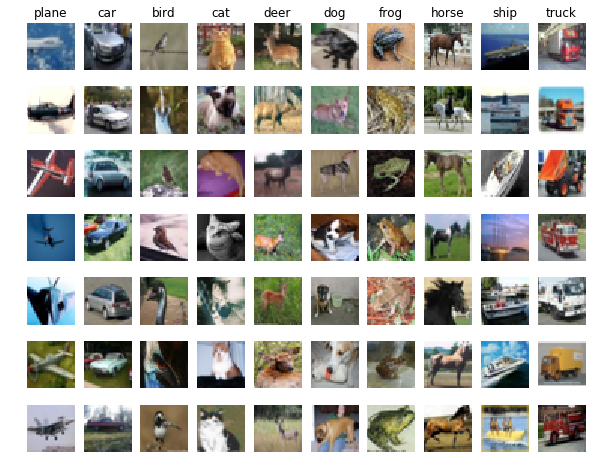

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [0]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


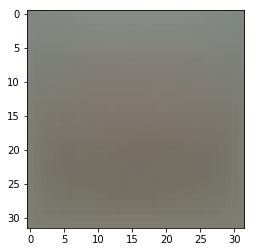

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [0]:
# Preprocessing: subtract the mean image for normalization
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Building Softmax Classfier

In [0]:
## One-hot coding
from scipy import sparse 
def convert_labels(y, C =10):
    """
    convert 1d label to a matrix label: each column of this 
    matrix coresponding to 1 element in y. In i-th column of Y, 
    only one non-zeros element located in the y[i]-th position, 
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y # shape (C, N)

In [0]:
# Calculation of softmax values
def softmax_stable(Z):
  """
  Compute softmax values for each sets of scores in Z
  each row of Z is a set of scores
  """
  # Z = Z.reshape(Z.shape[0], -1)
  e_Z = np.exp(Z-np.max(Z, axis=1, keepdims=True))
  A = e_Z / e_Z.sum(axis=1, keepdims=True)
  return A

In [0]:
# Calculation of softmax loss
def softmax_loss(X, Y, W, reg):
  """
  W: 2d numpy array of shape (d, C),
  each column correspoding to one output node
  X: 2d numpy array of shape (N, d), each row is one data point
  y: 1d numpy array -- label of each row of X
  """
  A = softmax_stable(X.dot(W))
  return - np.mean((Y.T)*np.log(A)+0.5*reg*np.sum(W*W))

In [0]:
def softmax_grad(X, Y, W):
  """
  W: 2d numpy array of shape (d, C),
  each column correspoding to one output node
  X: 2d numpy array of shape (N, d), each row is one data point
  y: 1d numpy array -- label of each row of X
  """
  A = softmax_stable(X.dot(W)) #shape of (N,C)
  E = A-Y # A-Y shape of (N, C)
  return X.T.dot(E)/X.shape[0]

## Mini-batch gradient descent (MGD)


We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do MGD to minimize the loss.

In [0]:
# Function to train softmax regression:
def softmax_fit(X, y, W, reg = 0.1, lr=0.1, nepoches = 100, tol = 1e-5, batch_size = 10):
  W_old = W.copy()
  ep = 0
  loss_history = []
  N = X.shape[0]
  nbatches = int(np.ceil(float(N)/batch_size))
  while ep < nepoches:
    ep +=1
    mix_ids = np.random.permutation(N) # mix data
    for i in range(nbatches):
      # get the i-th batch
      batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), N)]
      X_batch, y_batch = X[batch_ids], y[:,batch_ids]
      W -= lr*softmax_grad(X_batch, y_batch, W) #update gradient descent
    loss_history.append(softmax_loss(X, y, W, reg))
    if np.linalg.norm(W-W_old)/W.size < tol:
      break
    W_old = W.copy()
  return W, loss_history

## Building predict function and Estimating the accuracy

In [0]:
def softmax_predict(W, X):
  """
  predict output of each columns of X . Class of each x_i is determined by
  location of max probability. Note that classes are indexed from 0.
  """
  Z = X.dot(W)
  return np.argmax(softmax_stable(Z), axis=1)

def evaluate (W, X, Y):
  Y_pred = convert_labels(softmax_predict(W, X))
  acc = 100*np.mean(Y_pred==Y) #counting the number of True value over the total data points
  return acc

In [0]:
W = 0.0001*np.random.randn(X_train.shape[1], 10) #initalization of W
# For SGD
lrs = [1e-9, 1e-8, 1e-7, 1e-6]
regs = [0.1, 0.01, 0.001, 0.0001]
best_W = 0
best_acc = 0
for lr in lrs:
  for reg in regs:
    W_try, loss_history_try = softmax_fit(X_train, convert_labels(y_train), W, reg, lr)
    acc = evaluate(W_try, X_val, convert_labels(y_val))
    print("lr= {}, reg = {}, loss = {}, validation acc = {}".format(lr, reg, loss_history_try[-1], acc))
    if acc > best_acc:
      best_acc = acc
      best_W = W_try

lr= 1e-09, reg = 0.1, loss = 0.2313481572543478, validation acc = 82.32000000000001
lr= 1e-09, reg = 0.01, loss = 0.22964847146445838, validation acc = 82.66
lr= 1e-09, reg = 0.001, loss = 0.2288495599667495, validation acc = 83.0
lr= 1e-09, reg = 0.0001, loss = 0.2280389034755673, validation acc = 83.26
lr= 1e-08, reg = 0.1, loss = 0.224535515112231, validation acc = 83.7
lr= 1e-08, reg = 0.01, loss = 0.22446404654060947, validation acc = 84.1
lr= 1e-08, reg = 0.001, loss = 0.2218170715186995, validation acc = 84.94
lr= 1e-08, reg = 0.0001, loss = 0.2215721964056523, validation acc = 84.96000000000001
lr= 1e-07, reg = 0.1, loss = 0.2252412766441866, validation acc = 83.8
lr= 1e-07, reg = 0.01, loss = 0.225922963772854, validation acc = 83.58
lr= 1e-07, reg = 0.001, loss = 0.2194164785285197, validation acc = 84.74000000000001
lr= 1e-07, reg = 0.0001, loss = 0.2191914317545686, validation acc = 84.32
lr= 1e-06, reg = 0.1, loss = 0.24649367973393355, validation acc = 82.48
lr= 1e-06, re

In [0]:
acc = evaluate(best_W, X_test, convert_labels(y_test))
print("Accuracy on test data = {} %".format(acc))

Accuracy on test data = 82.74000000000001 %


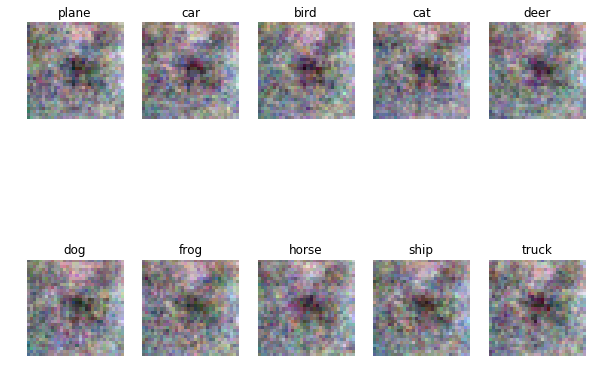

In [0]:
# Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.
w = best_W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])